## Imports
This section imports the necessary libraries and modules for the project.

In [ ]:
import sys
import os
import math
from datetime import datetime
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn
import cv2
import pywt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import timm

from sklearn.model_selection import GroupKFold
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer

from tqdm import tqdm
import albumentations as Al

# Import Neptune for experiment tracking
import neptune.new as neptune
from neptune.new.types import File

import logging

# Configure logging to record information to a file and display it on stdout
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[logging.FileHandler('debug.log'), logging.StreamHandler(sys.stdout)],
)

# Check the number of GPUs available on the system
ngpus_per_node = torch.cuda.device_count()
logging.info(f'Number of GPUs per node: {ngpus_per_node}')

# Configurations


In [2]:
# Configuration parameters for the experiment
params = {
    'data_dir': './X-ray/',
    'csv_file': './PadChest.csv',
    'csv_pos_neg_file': './PadChest.csv',
    'bone_removal_path': './bone_supressed/',
    'model': 'densenet121',
    'device': 'cuda',
    'lr': 0.0002,
    'weight_decay': 1e-5,
    'batch_size': 16,
    'num_workers': 8,
    'epochs': 100,
    'image_height': 380,
    'image_width': 380,
    'embedding_size': 512,
    'loss_weights': [0.8, 0.2],
    'seed': 14,
    'notes': '',
}

# Initialize Neptune project for experiment tracking
run_neptune = neptune.init(project = 'polyrepresentation/siamese', mode = 'debug')

# Log the experiment parameters to Neptune
run_neptune['params'] = params

In [5]:
# Clear GPU cache
torch.cuda.empty_cache()

# Set seeds
torch.manual_seed(params['seed'])
torch.cuda.manual_seed(params['seed'])
torch.cuda.manual_seed_all(params['seed'])
np.random.seed(params['seed'])
torch.backends.cudnn.benchmark     = False
torch.backends.cudnn.deterministic = True

In [ ]:
# Read the CSV file containing data
df = pd.read_csv(
    params["csv_file"],
    sep = ";",
    converters = {"labels": lambda x: x.strip("[]' ,").replace("'", "").split(", ")},
)

In [7]:
# Create a MultiLabelBinarizer to one-hot encode the 'labels' column
mlb = MultiLabelBinarizer(sparse_output = True)

df = df.join(
    pd.DataFrame.sparse.from_spmatrix(
        mlb.fit_transform(df['labels']), 
        index = df.index, 
        columns = mlb.classes_
    ).sparse.to_dense().add_prefix('cl_'))
del mlb

# Drop the 'cl_normal' column
df.drop(columns = 'cl_normal', inplace  =  True)
df.head()

,path,patient_id,sex,age,projection,labels,cl_COPD signs,cl_NSG tube,cl_air trapping,cl_alveolar pattern,...,cl_kyphosis,cl_laminar atelectasis,cl_nodule,cl_pacemaker,cl_pleural effusion,cl_pneumonia,cl_scoliosis,cl_unchanged,cl_vascular hilar enlargement,cl_vertebral degenerative changes
0,BIMCV-PadChest-FULL/raw/0/20536686640136348236...,839860488694292331637988235681460987,F,84.0,PA,[normal],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,BIMCV-PadChest-FULL/raw/0/13580341550492351507...,313572750430997347502932654319389875966,M,86.0,PA,"[chronic changes, kyphosis]",0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,BIMCV-PadChest-FULL/raw/0/11385534377421603110...,50783093527901818115346441867348318648,F,90.0,PA,[chronic changes],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,BIMCV-PadChest-FULL/raw/0/31390330262930000748...,3707275269754751392247446521222810702,M,39.0,AP,"[unchanged, alveolar pattern, interstitial pat...",0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,BIMCV-PadChest-FULL/raw/0/3137231742710829928-...,93535126770783451980359712286922420997,M,58.0,PA,"[laminar atelectasis, pleural effusion, apical...",0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [8]:
# Define the number of output classes and their names
out_classes = df.columns.str.startswith('cl_').sum()
column_names = df.columns[df.columns.str.startswith('cl_')].to_list()

In [10]:
# Split the data into training and validation sets using GroupKFold
gkf = GroupKFold(n_splits = 5)

# Filter columns for labels (X) and other features (y)
filter_col = [col for col in df if col.startswith('cl_')]
X = df[filter_col]
filter_col = [col for col in df if not col.startswith('cl_')]
y = df[filter_col]

# Perform the train-validation split based on groups (patient_id)
## repeating patient_id take only to one folder: either train or valid
## equally distribute labels to train and valid
train_ix, valid_ix = next(gkf.split(X, y, groups = df.path))
train_df, valid_df = df.loc[train_ix], df.loc[valid_ix]
del filter_col, X, y

# Create APN Dataset


In [13]:
# Add class weighting
number_of_samples_of_the_class = df[
    df.columns[pd.Series(df.columns).str.startswith('cl_')]
].sum(axis = 2, numeric_only = True)

total_number_of_samples = (
    df[df.columns[pd.Series(df.columns).str.startswith('cl_')]]
    .sum(axis = 0, numeric_only = True)
    .sum()
)

class_weights = [
    1 - item / total_number_of_samples for item in number_of_samples_of_the_class
]

del number_of_samples_of_the_class, total_number_of_samples

In [ ]:
# Define the transformations to be applied to images
transformations = Al.Compose(
    [
        Al.Resize(params['image_height'], params['image_width']),
        Al.ShiftScaleRotate(shift_limit = 0.05, scale_limit = 0.05, rotate_limit = 15, p = 0.5),
        Al.OneOf(
            [
                Al.OneOf(
                    [
                        Al.ISONoise(),
                        Al.GaussNoise(),
                    ],
                    p = 0.5,
                ),
                Al.OneOf(
                    [
                        Al.MotionBlur(p = 0.2),
                        Al.MedianBlur(blur_limit = 3, p = 0.1),
                        Al.Blur(blur_limit = 3, p = 0.1),
                    ],
                    p = 0.5,
                ),
            ],
            p = 0.5,
        ),
        Al.OneOf(
            [
                Al.OpticalDistortion(p = 0.3),
                Al.GridDistortion(p = 0.1),
            ],
            p = 0.3,
        ),
        Al.OneOf(
            [
                Al.CLAHE(clip_limit = 2),
                Al.Sharpen(),
                Al.Emboss(),
                Al.RandomBrightnessContrast(),
            ],
            p = 0.3,
        ),
        Al.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
    ]
)

# Define basic transformations without augmentations
transformations_basic = Al.Compose(
    [
        Al.Resize(params['image_height'], params['image_width']),
        Al.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
    ]
)

In [ ]:
def three_channel(image, name):
    """
    Adds three channels to a grayscale medical image.

    Args:
        image (numpy.ndarray): The input grayscale medical image.
        name (str): The name of the image.

    Returns:
        numpy.ndarray: A three-channel image with the following channels:
            - Channel 0: Original grayscale image.
            - Channel 1: Wavelet transform of the grayscale image.
            - Channel 2: Image of lungs without ribs.

    Note:
        The function uses wavelet transform and image processing techniques to create the additional channels.

    Example:
        # Load a grayscale medical image
        grayscale_image = cv2.imread('medical_image.png', cv2.IMREAD_GRAYSCALE)

        # Add three channels to the grayscale image
        three_channel_image = three_channel(grayscale_image, 'medical_image.png')
    """

    _, (LH, HL, HH) = pywt.dwt2(image[:, :, 0], 'bior1.3')
    image[:, :, 1] = cv2.resize(
        np.average([LH, HL, HH], axis = 0),
        (params['image_height'], params['image_width']),
        interpolation=cv2.INTER_AREA,
    )
    image[:, :, 1] = (
        255 * (image[:, :, 1] - np.min(image[:, :, 1])) / np.ptp(image[:, :, 1])
    )

    try:
        name = os.path.join(
            params['bone_removal_path'], '.suppressedBone.'.join(name.rsplit('.', 1))
        )
        bone = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
        image[:, :, 2] = cv2.resize(
            bone, dsize = (params['image_height'], params['image_width'])
        )
    except:
        print('FAILED TO LOAD: {}'.format(name))
        logging.warning('FAILED TO LOAD: {}'.format(name))
        image[:, :, 2] = image[:, :, 0]

    image[:, :, 2] = (
        255 * (image[:, :, 2] - np.min(image[:, :, 2])) / np.ptp(image[:, :, 2])
    )
    image[:, :, 0] = (
        255 * (image[:, :, 0] - np.min(image[:, :, 0])) / np.ptp(image[:, :, 0])
    )

    return image.astype(np.uint8)

In [16]:
class APN_Dataset(Dataset):
    """
    Custom dataset class for creating the Anchor-Positive-Negative (APN) dataset.

    Args:
        df (DataFrame): The DataFrame containing dataset information.
        transform (callable, optional): A function/transform to apply to the images. Default is None.
        channel (callable, optional): A function/transform to apply to the image channels. Default is None.
        onlyTest (bool, optional): Flag to indicate if the dataset is for testing only. Default is False.

    Attributes:
        df (DataFrame): The DataFrame containing dataset information.
        df_pos_neg (DataFrame): A DataFrame containing positive and negative sample information.
        transform (callable, optional): A function/transform to apply to the images.
        transform_basic (callable): A basic image transformation.
        channel (callable, optional): A function/transform to apply to the image channels.
        onlyTest (bool): Flag to indicate if the dataset is for testing only.
        clusters (dict): A dictionary to store clusters of samples based on common labels.
        list_of_cluster_keys (list): A list of cluster keys.

    Methods:
        __len__(): Returns the total number of samples in the dataset.
        _find_positive_and_negative(row): Finds a positive and negative sample for a given anchor sample.
        __getitem__(idx): Returns the anchor, positive, and negative samples along with their labels and paths.

    Example:
        dataset = APN_Dataset(df, transform = data_transform, channel = channel_transform, onlyTest = False)
    """

    def __init__(self, df, transform = None, channel = None, onlyTest = False):
        """
        Initializes the APN_Dataset with the provided parameters.
        """
        self.df = df
        self.df_pos_neg = pd.read_csv(
            params['csv_pos_neg_file'],
            sep = ';',
            converters = {
                'labels': lambda x: x.strip("[]" ,'')
                .replace("'", '')
                .replace('  ', ' ')
                .split(', ')
            },
        )
        self.transform = transform
        self.transform_basic = transformations_basic
        self.channel = channel
        self.onlyTest = onlyTest

        self.clusters = {}

        for item in self.df_pos_neg.to_numpy():  # iterate over classes
            for illness in item[5]:
                if illness in self.clusters:
                    self.clusters[illness].append(item)
                else:
                    self.clusters[illness] = [item]

        self.list_of_cluster_keys = list(self.clusters.keys())

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.df)

    def _find_positive_and_negative(self, row):
        """
        Finds a positive and negative sample for a given anchor sample.

        Args:
            row: A row from the dataset.

        Returns:
            final_positive (str): File path of the positive sample.
            final_negative (str): File path of the negative sample.
        """
        anchor = row.path

        # draw a random illness from Anchor
        while True:
            key = random.choice(row.labels)
            if len(self.clusters[key]) > 2:
                break

        #  1. look for Positive
        max_number_of_same_classes = -1
        min_number_of_dissimilar_classes = 999
        final_positive = random.choice(self.clusters[key])

        look_for_more_similar = 0

        # sort all potential Positive randomly - to prevent taking every time same potential Positive
        # tip: look for Positive any in the same class examples
        for randomly_selected_positive in sorted(
            self.clusters[key].copy(), key = lambda _: random.random()
        ):
            if anchor[0] !=  randomly_selected_positive[0]:
                # count how many classes are same
                classes_same_with_anchor = [
                    v for v in anchor[5] if v in randomly_selected_positive[5]
                ]
                classes_different_than_in_anchor = list(
                    set(randomly_selected_positive[5]).__xor__(set(anchor[5]))
                )

                # consider an example of Positive if:
                #                           has more classes in common with Anchor than the previously remembered one,
                #                           has fewer classes distinct from Anchor and is not the same as Anchor
                if max_number_of_same_classes < len(classes_same_with_anchor):
                    max_number_of_same_classes = len(classes_same_with_anchor)
                    min_number_of_dissimilar_classes = len(
                        classes_different_than_in_anchor
                    )
                    final_positive = randomly_selected_positive

                elif max_number_of_same_classes ==  len(
                    classes_same_with_anchor
                ) and min_number_of_dissimilar_classes >=  len(
                    classes_different_than_in_anchor
                ):
                    max_number_of_same_classes = len(classes_same_with_anchor)
                    min_number_of_dissimilar_classes = len(
                        classes_different_than_in_anchor
                    )
                    final_positive = randomly_selected_positive

                    # if all Positive contain all classes from Anchor
                    if len(classes_different_than_in_anchor) < 3:
                        # stop searching when all classes are same with Anchor classes or you have looked for them 10 times
                        if (
                            len(classes_different_than_in_anchor) ==  0
                            or look_for_more_similar >=  200
                        ):
                            break
                        look_for_more_similar +=  1

        # 2. look for Negative
        negative_key = random.choice(self.list_of_cluster_keys)
        final_negative = random.choice(self.clusters[negative_key])

        # search until Negative will not have any classes in common with Anchor and Positive
        while (
            negative_key ==  key
            or negative_key in anchor[5]
            or negative_key in final_positive[5]
        ):
            # tip: every class have the same probability to be chosen for Negative
            negative_key = random.choice(self.list_of_cluster_keys)
        while any(
            x in final_positive[5] for x in final_negative[5]
        ):  # or any(x in anchor[5] for x in final_negative[5])
            final_negative = random.choice(self.clusters[negative_key])

        return final_positive[0], final_negative[0]

    def __getitem__(self, idx):
        """
        Returns the anchor, positive, and negative samples along with their labels and paths.

        Args:
            idx (int): Index of the sample in the dataset.

        Returns:
            A_img (ndarray): Anchor sample image.
            P_img (ndarray): Positive sample image.
            N_img (ndarray): Negative sample image.
            labels (Tensor): Ground truth labels for the samples.
            path (str): File path of the anchor sample.
        """
        
        # select row
        row = self.df.iloc[idx]

        positive, negative = self._find_positive_and_negative(row)

        if self.onlyTest:
            A_img = cv2.imread(params['data_dir'] + row.path, cv2.IMREAD_COLOR)

            if self.transform is not None:
                A_img = self.transform(image = A_img)['image']

            if self.channel is not None:
                A_img = self.channel(image = A_img, name = row.path)

            return A_img, '', '', '', row

        A_img = cv2.imread(params['data_dir'] + row.path, cv2.IMREAD_COLOR)
        P_img = cv2.imread(params['data_dir'] + positive, cv2.IMREAD_COLOR)
        N_img = cv2.imread(params['data_dir'] + negative, cv2.IMREAD_COLOR)

        if self.channel is not None:
            A_img = self.transform_basic(image = A_img)['image']
            P_img = self.transform_basic(image = P_img)['image']
            N_img = self.transform_basic(image = N_img)['image']

            A_img = self.channel(image = A_img, name = row.path)
            P_img = self.channel(image = P_img, name = positive)
            N_img = self.channel(image = N_img, name = negative)

        if self.transform is not None:
            A_img = self.transform(image = A_img)['image']
            P_img = self.transform(image = P_img)['image']
            N_img = self.transform(image = N_img)['image']

        return (
            A_img,
            P_img,
            N_img,
            torch.from_numpy(row.to_numpy()[-out_classes:].astype(np.float16)),
            row.path,
        )

In [17]:
# Create training and validation datasets
trainset = APN_Dataset(train_df, transform=transformations, channel=three_channel)
validset = APN_Dataset(valid_df, transform=transformations, channel=three_channel)

logging.info(f'Size of trainset: {len(trainset)}')
logging.info(f'Size of validset: {len(validset)}')

2023-03-31 16:25:15,357 [INFO] Size of trainset: 79644
2023-03-31 16:25:15,358 [INFO] Size of validset: 19912


2023-03-31 16:25:15,638 [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2023-03-31 16:25:15,642 [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2023-03-31 16:25:15,645 [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


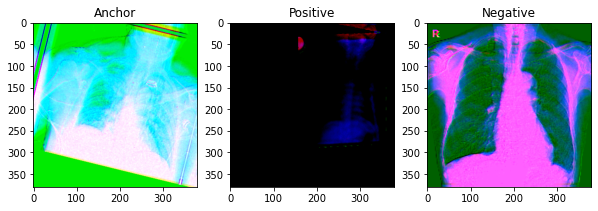

2023-03-31 16:25:15,984 [INFO] Image uploaded


In [18]:
idx = 3
A, P, N, _, _ = validset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5))

ax1.set_title('Anchor')
ax1.imshow(A)

ax2.set_title('Positive')
ax2.imshow(P)

ax3.set_title('Negative')
ax3.imshow(N)

plt.savefig('apn-sample-image.png')
plt.show()
run_neptune['sample_image'].upload('apn-sample-image.png')
logging.info('Image uploaded')

2023-03-31 16:25:16,718 [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


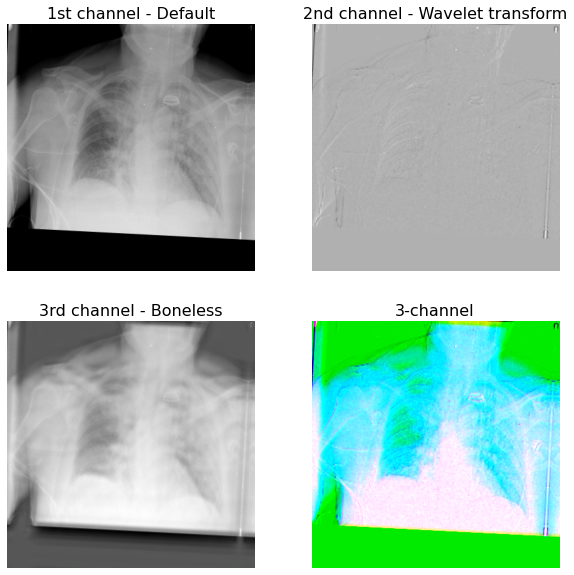

2023-03-31 16:25:16,978 [INFO] Image uploaded


In [19]:
idx = 3
A, P, N, _, _ = validset[idx]

f, ax = plt.subplots(2, 2, figsize = (10, 10))

ax[0, 0].set_title('1st channel - Default', fontsize = 16)
ax[0, 0].imshow(A[:, :, 0], cmap = 'gray')
ax[0, 0].axis('off')

ax[0, 1].set_title('2nd channel - Wavelet transform', fontsize = 16)
ax[0, 1].imshow(A[:, :, 1], cmap = 'gray')
ax[0, 1].axis('off')

ax[1, 0].set_title('3rd channel - Boneless', fontsize = 16)
ax[1, 0].imshow(A[:, :, 2], cmap = 'gray')
ax[1, 0].axis('off')

ax[1, 1].set_title('3-channel', fontsize = 16)
ax[1, 1].imshow(A)
ax[1, 1].axis('off')

plt.savefig('apn-sample-channels.jpg')
plt.show()
run_neptune['channels_image'].upload('apn-sample-channels.jpg')
logging.info('Image uploaded')

del idx, A, P, N, f, ax

# Load Dataset into Batches


In [20]:
trainloader = DataLoader(
    trainset,
    batch_size = params['batch_size'],
    shuffle = True,
    num_workers = params['num_workers'],
    pin_memory = False,
)
validloader = DataLoader(
    validset,
    batch_size = params['batch_size'],
    num_workers = params['num_workers'],
    pin_memory = False,
)

In [21]:
logging.info(f'No. of batches in trainloader : {len(trainloader)}')
logging.info(f'No. of batches in validloader : {len(validloader)}')

2023-03-31 16:25:18,079 [INFO] No. of batches in trainloader : 9956
2023-03-31 16:25:18,080 [INFO] No. of batches in validloader : 2489


# Create Model


In [23]:
class APN_Model(nn.Module):
    def __init__(self, out_classes, emb_size = params['embedding_size']):
        """
        Custom Siamese network model for Anchor-Positive-Negative (APN) triplet loss.

        Args:
            out_classes (int): Number of output classes.
            emb_size (int, optional): Size of the embedding space. Default is params['embedding_size'].

        Methods:
            forward(images): Forward pass of the Siamese network.

        Example:
            model = APN_Model(out_classes = 10, emb_size = 256)
        """

        super(APN_Model, self).__init__()
        self.out_classes = out_classes
        tmp_size = (emb_size + self.out_classes) // 2

        self.backbone = timm.create_model(params['model'], pretrained=True)

        self.backbone.classifier = nn.Linear(
            in_features=self.backbone.classifier.in_features, out_features=emb_size
        )
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(emb_size)
        self.drop1 = nn.Dropout(0.50)

        self.fc2 = nn.Linear(emb_size, tmp_size)
        self.bn2 = nn.BatchNorm1d(tmp_size)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.50)

        self.fc3 = nn.Linear(tmp_size, self.out_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        """
        Forward pass of the Siamese network.

        Args:
            images (Tensor): Input tensor containing anchor, positive, and negative samples.
        Returns:
            embeddings (list of Tensor): Embeddings for anchor, positive, and negative samples.
            cl (Tensor): Output from the classification network.
        """
        embeddings = self.backbone(images)

        cl = self.relu1(embeddings)
        cl = self.bn1(cl)
        cl = self.drop1(cl)

        cl = self.fc2(cl)
        cl = self.bn2(cl)
        cl = self.relu2(cl)
        cl = self.drop2(cl)

        cl = self.fc3(cl)
        cl = self.sigmoid(cl)

        return [embeddings, cl]

In [24]:
# Create an instance of the APN_Model
model = APN_Model(out_classes = out_classes)
# model.load_state_dict(torch.load('./model_weights/best_model.pt'))
model.to(params['device'])

2023-03-31 16:25:18,631 [INFO] Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/densenet121_ra-50efcf5c.pth)


APN_Model(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (act): ReLU(inplace=True)
      )
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): DenseBlock(
        (denselayer1): DenseLayer(
          (norm1): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (act): ReLU(inplace=True)
          )
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNormAct2d(
            128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (act): ReLU(inplace=True)
          )
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2

# Loss


In [27]:
class LossWrapper(nn.Module):
    def __init__(self, loss_weights):
        """
        Custom loss wrapper class for combining triplet loss and classification loss.

        Args:
            loss_weights (list): List of weights for combining the two losses.
        """
        super(LossWrapper, self).__init__()
        self.loss_weights = loss_weights
        self.class_weights = torch.nn.Parameter(
            torch.tensor(class_weights, dtype = torch.half)
        ).to(params['device'])

    def forward(self, APN_embs, A_cl, labels):
        """
        Forward pass of the loss wrapper.

        Args:
            embeddings (list): List of embeddings for anchor, positive, and negative samples.
            classifier_outputs (Tensor): Output from the classification network.
            labels (Tensor): Ground truth labels.
        Returns:
            loss (Tensor): Combined loss.
            loss_triplet (Tensor): Triplet loss.
            loss_classification (Tensor): Classification loss.
        """
        labels = labels.to(params['device'])

        triplet_loss = nn.TripletMarginLoss()
        loss0 = triplet_loss(APN_embs[0], APN_embs[1], APN_embs[2])

        classification_loss = nn.MultiLabelSoftMarginLoss()
        loss1 = classification_loss(A_cl, labels)

        return loss0 * self.loss_weights[0] + loss1 * self.loss_weights[1], loss0, loss1

In [28]:
criterion = LossWrapper(params['loss_weights'])
optimizer = torch.optim.Adam(
    model.parameters(), lr = params['lr'], weight_decay = params['weight_decay']
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.5)

# Create Train and Eval function


In [29]:
def train_fn(model, dataloader, optimizer, criterion):
    """
    Perform training on the training dataset using the provided model, optimizer, and criterion.

    Args:
        model (nn.Module): The neural network model for training.
        dataloader (DataLoader): DataLoader for loading training data.
        optimizer: Optimizer for updating model parameters.
        criterion: Loss function for training.
    Returns:
        train_loss (float): Training loss.
        train_loss_siamese (float): Training loss for the siamese network.
        train_loss_classif (float): Training loss for the classification network.
    """
    model.train()
    total_loss = total_loss_siamese = total_loss_classif = 0.0

    for A, P, N, A_label, _ in tqdm(dataloader):
        A, P, N = A.transpose(-1, 1), P.transpose(-1, 1), N.transpose(-1, 1)

        A, P, N = A.to(params['device']), P.to(params['device']), N.to(params['device'])

        A_embs, A_cl = model(A)
        del A
        P_embs, _ = model(P)
        del P
        N_embs, _ = model(N)
        del N

        loss, loss_siamese, loss_classif = criterion(
            [A_embs, P_embs, N_embs], A_cl, A_label
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_loss_siamese += loss_siamese.item()
        total_loss_classif += loss_classif.item()

    return (
        total_loss / len(dataloader),
        total_loss_siamese / len(dataloader),
        total_loss_classif / len(dataloader),
    )

In [30]:
def eval_fn(model, dataloader, criterion):
    """
    Perform evaluation on the validation dataset using the provided model and criterion.

    Args:
        model (nn.Module): The neural network model for evaluation.
        dataloader (DataLoader): DataLoader for loading validation data.
        criterion: Loss function for evaluation.
    Returns:
        valid_loss (float): Validation loss.
        valid_values (dict): Dictionary containing validation results.
        valid_loss_siamese (float): Validation loss for the siamese network.
        valid_loss_classif (float): Validation loss for the classification network.
    """
    model.eval()
    total_loss = total_loss_siamese = total_loss_classif = 0.0
    test_values = {}
    test_values['A_cl'] = []
    test_values['A_prob'] = []
    test_values['A_label'] = []

    with torch.no_grad():
        for A, P, N, A_label, _ in tqdm(dataloader):
            A, P, N = A.transpose(-1, 1), P.transpose(-1, 1), N.transpose(-1, 1)

            A, P, N = (
                A.to(params['device']),
                P.to(params['device']),
                N.to(params['device']),
            )

            A_embs, A_cl = model(A)
            P_embs, _ = model(P)
            N_embs, _ = model(N)

            loss, loss_siamese, loss_classif = criterion(
                [A_embs, P_embs, N_embs], A_cl, A_label
            )

            test_values['A_cl'].extend(torch.round(A_cl).type(torch.int8).tolist())
            test_values['A_prob'].extend(A_cl.type(torch.float64).tolist())
            test_values['A_label'].extend(A_label.type(torch.int8).tolist())

            total_loss += loss.item()
            total_loss_siamese += loss_siamese.item()
            total_loss_classif += loss_classif.item()

    return (
        total_loss / len(dataloader),
        test_values,
        total_loss_siamese / len(dataloader),
        total_loss_classif / len(dataloader),
    )

In [31]:
def eval_metrics(labels, predictions, probabilities):
    """
    Evaluate various classification metrics and log them using Neptune.

    Args:
        labels (list): True labels for the dataset.
        predictions (list): Predicted labels for the dataset.
        probabilities (list): Predicted probabilities for the dataset.
    Returns:
        acc (float): Accuracy score.
    """
    # Calculate and log accuracy
    acc = metrics.accuracy_score(labels, predictions)
    run_neptune[f'valid_acc'].log(acc)

    # Calculate and log multilabel confusion matrix
    conf_matrix = metrics.multilabel_confusion_matrix(labels, predictions)

    conf_matrix_fig, ax = plt.subplots(
        math.ceil(conf_matrix.shape[0] / 6),
        6,
        figsize = (5.0 * math.ceil(conf_matrix.shape[0] / 6), 2.0 * 6),
    )

    for axes, confusion_matrix, class_label in zip(
        ax.flatten(), conf_matrix, column_names
    ):
        df_cm = pd.DataFrame(
            confusion_matrix,
            index = ['N', 'Y'],
            columns = ['N', 'Y'],
        )

        try:
            heatmap = sn.heatmap(df_cm, annot = True, fmt = 'd', cbar = False, ax = axes)
        except ValueError:
            raise ValueError('Confusion matrix values must be integers.')
        heatmap.yaxis.set_ticklabels(
            heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 14
        )
        heatmap.xaxis.set_ticklabels(
            heatmap.xaxis.get_ticklabels(), rotation = 45, ha = 'right', fontsize = 14
        )
        axes.set_ylabel('True label')
        axes.set_xlabel('Predicted label')
        axes.set_title('CM ' + class_label)

    conf_matrix_fig.tight_layout()
    plt.savefig('valid_multilabel_confusion_matrix.jpg')

    run_neptune[f'valid_multilabel_confusion_matrix'].upload(
        File.as_image(conf_matrix_fig)
    )
    plt.close('all')

    # Calculate and log classification report
    report = metrics.classification_report(
        labels, predictions, output_dict = True, zero_division = 0
    )
    report = {key: report[key]['f1-score'] for key in report}

    for key, value in report.items():
        run_neptune[
            f'valid_f1_{column_names[int(key)] if key.isnumeric() else key}'
        ].log(value)

    # Calculate and log F1-score (micro and weighted)
    f1 = metrics.f1_score(labels, predictions, average = 'micro')
    run_neptune[f'valid_f1_micro'].log(f1)

    f1 = metrics.f1_score(labels, predictions, average = 'weighted')
    run_neptune[f'valid_f1_weighted'].log(f1)

    # Calculate and log precision (micro and weighted)
    prec = metrics.precision_score(labels, predictions, average = 'micro')
    run_neptune[f'valid_precision_micro'].log(prec)

    prec = metrics.precision_score(labels, predictions, average = 'weighted')
    run_neptune[f'valid_precision_weighted'].log(prec)

    try:
        # Calculate and log coverage error, label ranking average precision score, label ranking loss
        cov_error = metrics.coverage_error(labels, probabilities)
        run_neptune[f'valid_coverage_error'].log(cov_error)

        lraps = metrics.label_ranking_average_precision_score(labels, probabilities)
        run_neptune[f'valid_label_ranking_average_precision_score'].log(lraps)

        lrl = metrics.label_ranking_loss(labels, probabilities)
        run_neptune[f'valid_label_ranking_loss'].log(lrl)

        # Calculate and log average precision (micro)
        av_prec = metrics.average_precision_score(
            labels, probabilities, average = 'micro'
        )
        run_neptune[f'valid_average_precision'].log(av_prec)
    except:
        print(f'probabilities: {probabilities}')

        if np.isnan(probabilities).any():
            print('The Array contain NaN values')
        else:
            print('The Array does not contain NaN values')

    return acc

In [32]:
del valid_df, validset

# Create Training Loop


In [ ]:
logging.info('Training started')
best_valid_loss = np.Inf
curr_time = round(datetime.timestamp(datetime.now()))
run_neptune[f'model_time'].log(curr_time)

for i in range(params['epochs']):
    train_loss, train_loss_siamese, train_loss_classif = train_fn(
        model, trainloader, optimizer, criterion
    )
    valid_loss, valid_values, valid_loss_siamese, valid_loss_classif = eval_fn(
        model, validloader, criterion
    )

    run_neptune[f'train_loss'].log(train_loss)
    run_neptune[f'train_loss_siamese'].log(train_loss_siamese)
    run_neptune[f'train_loss_classif'].log(train_loss_classif)

    run_neptune[f'valid_loss'].log(valid_loss)
    run_neptune[f'valid_loss_siamese'].log(valid_loss_siamese)
    run_neptune[f'valid_loss_classif'].log(valid_loss_classif)

    if valid_loss < best_valid_loss:
        torch.save(
            model.state_dict(), 'model_weights/best_model_{}.pt'.format(curr_time)
        )
        torch.save(
            model.state_dict(),
            'model_weights/best_model_{}_epoch-{}.pt'.format(curr_time, i + 1),
        )
        best_valid_loss = valid_loss
        run_neptune['model_weights/epoch-{}-time-{}'.format(i + 1, curr_time)].upload(
            './model_weights/best_model_{}_epoch-{}.pt'.format(curr_time, i + 1)
        )
        logging.info('SAVED_WEIGHTS_SUCCESS')

    acc = eval_metrics(
        valid_values['A_label'], valid_values['A_cl'], valid_values['A_prob']
    )

    logging.info(
        f'model: {curr_time}, EPOCHS : {i+1}, train_loss : {train_loss}, valid_loss : {valid_loss}, valid_acc: {acc}'
    )

    # learning_rate_decay_step every 10 epochs
    lr_scheduler.step()

run_neptune['model_weights/best_model.pt'].upload(
    './model_weights/best_model_{}.pt'.format(curr_time)
)
logging.info(f'Training ended for model: {curr_time}')

# Create test dataset


In [ ]:
# Create a test dataset for anchor embeddings
testset = APN_Dataset(df, transform = transformations_basic, onlyTest = True)

## Get Anchor Embeddings


In [ ]:
def get_encodings_csv(model, df):
    """
    Compute embeddings for all images in the dataset using the provided model and save them to a CSV file.
    
    Args:
        model (nn.Module): The neural network model for computing embeddings.
        dataloader (DataLoader): DataLoader for loading images from the dataset.
        csv_filename (str): The filename for saving the CSV file with embeddings.
    """
    encodings = []
    model.eval()
    with torch.no_grad():
        for idx in tqdm(range(len(testset))):
            A, _, _, _, row = testset[idx]

            A = np.moveaxis(A, -1, 0)
            A = torch.from_numpy(A)

            A = A.to(params['device'])
            A_enc = model(A.unsqueeze(0).float())
            tmp = []
            tmp.extend(
                [row.path, row.labels, row.patient_id, row.sex, row.age, row.projection]
            )
            tmp.extend(A_enc[0].detach().cpu().tolist()[0])
            encodings.append(tmp)

        col_names = ['Anchor', 'labels', 'patient_id', 'sex', 'age', 'projection']
        col_names.extend(list(range(params['embedding_size'])))

        df_enc = pd.DataFrame(encodings, columns = col_names)

        return df_enc

In [ ]:
model.load_state_dict(torch.load('model_weights/best_model_{}.pt'.format(curr_time)))

In [ ]:
# Compute embeddings for all images in the test dataset and save them to a CSV file
df_enc = get_encodings_csv(model, df)
df_enc.to_csv('database.csv', index = False)
run_neptune['database_vectorized'].upload('database.csv')
logging.info('Database vectorized')
df_enc.head()

2023-03-22 18:31:46,668 [INFO] Database vectorized


,Anchor,labels,patient_id,sex,age,projection,0,1,2,3,...,502,503,504,505,506,507,508,509,510,511
0,BIMCV-PadChest-FULL/raw/0/20536686640136348236...,[normal],839860488694292331637988235681460987,F,84.0,PA,-0.012022,0.118399,-0.136466,0.327500,...,-0.758866,-0.114324,0.068084,0.429849,0.401266,-0.458793,0.231641,-0.422721,0.191649,-0.059095
1,BIMCV-PadChest-FULL/raw/0/13580341550492351507...,"[chronic changes, kyphosis]",313572750430997347502932654319389875966,M,86.0,PA,-0.319439,0.042895,0.237374,0.272904,...,-0.350338,-0.208682,0.337436,0.361737,0.162173,-0.189120,0.055667,0.031716,0.341949,-0.106223
2,BIMCV-PadChest-FULL/raw/0/11385534377421603110...,[chronic changes],50783093527901818115346441867348318648,F,90.0,PA,-0.135763,-0.013282,-0.351795,0.027358,...,-0.417060,-0.064385,-0.002726,0.203044,0.393449,-0.167944,0.279157,-0.385572,0.229610,-0.247936
3,BIMCV-PadChest-FULL/raw/0/31390330262930000748...,"[unchanged, alveolar pattern, interstitial pat...",3707275269754751392247446521222810702,M,39.0,AP,-0.444667,0.059524,-0.373592,0.249283,...,-0.573174,0.004053,-0.058767,0.000897,0.213593,-0.668421,0.517619,-0.453805,0.252479,0.222424
4,BIMCV-PadChest-FULL/raw/0/3137231742710829928-...,"[laminar atelectasis, pleural effusion, apical...",93535126770783451980359712286922420997,M,58.0,PA,-0.205269,0.003002,0.047776,0.274422,...,-0.451821,-0.257543,-0.167157,0.187255,0.067159,-0.264405,0.194729,-0.297856,0.339527,0.140521


In [ ]:
# Stop Neptune logging
run_neptune.stop()
logging.info('Neptune logging stopped')

Shutting down background jobs, please wait a moment...
Done!
2023-03-22 18:31:47,083 [INFO] Neptune logging stopped
